# Grove Temperature Sensor 1.2

In this notebook, the [Grove Temperature Sensor v1.2](http://www.seeedstudio.com/wiki/Grove_-_Temperature_Sensor_V1.2) functionality using [Grove I2C ADC](http://www.seeedstudio.com/wiki/Grove_-_I2C_ADC) is illustrated.

You can read a single value of temperature or can read multiple values at a desired interval for a desired duration.

Additionally, at the end of this notebook, we highlight a Python only solution with single-sample read functionality.

<tr>
<td> <img src=http://www.xilinx.com/content/dam/xilinx/imgs/prime/ZYBO_revB-top-1000x755%20(1).jpg alt="Drawing" style="width: 250px;"/> </td>
<td> <img src=http://www.xess.com/static/media/product/product_cover_1.jpg alt="Drawing" style="width: 250px;"/> </td>
<td> <img src=http://www.seeedstudio.com/wiki/images/b/b0/Temperature1.jpg alt="Drawing" style="width: 250px;"/> </td>
</tr>

### 1. Load overlay.

In [1]:
from pynq.pl import Overlay
Overlay("pmod.bit").download()

### 2. Read single temperature
This example shows on how to get a single temperature sample from the Grove TMP sensor.

The Grove ADC is assumed to be attached to the GR4 connector of the StickIt. The StickIt module is assumed to be plugged in the 1st PMOD labeled JB. The Grove TMP sensor is connected to the other connector of the Grove ADC.

Grove ADC provides a raw sample which is converted into resistance first and then converted into temperature.

In [2]:
import math
from pynq.pmods import Grove_TMP

#: Grove Stickit is connected to PMOD 1 labeled JB
#: Grove ADC is connected to GR 4. 
tmp = Grove_TMP(1, 4)
temperature = tmp.read()
print(float("{0:.2f}".format(temperature)),'degree Celsius')

27.65 degree Celsius


### 3. Start logging once every half a second for 10 seconds
During the execution, you can touch the temperature sensor to see the temperature profile.

You can vary the logging interval and the duration by changing the values 100 and 10 to the desired values. The raw samples are stored in the internal memory, and converted into the temperature readings.

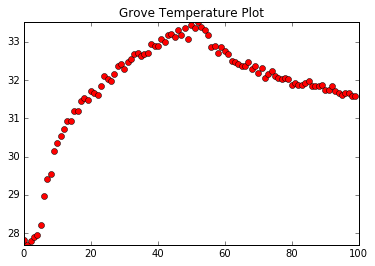

In [3]:
import time

%matplotlib inline
import matplotlib.pyplot as plt

tmp.set_log_interval_ms(100)
tmp.start_log()
time.sleep(10) # Change input during this time
tmp_log = tmp.get_log()

plt.plot(range(len(tmp_log)), tmp_log, 'ro')
plt.title('Grove Temperature Plot')
min_tmp_log = min(tmp_log)
max_tmp_log = max(tmp_log)
plt.axis([0, len(tmp_log), min_tmp_log, max_tmp_log])
plt.show()

### 4. A Pure Python class to exercise the AXI IIC Controller inheriting from PMOD_IIC

In [4]:
# Python Class for Grove Temperature Sensor
# Ported from http://www.seeedstudio.com/wiki/Grove_-_Temperature_Sensor 

from time import sleep
from math import log
from pynq.pmods import pmod_const
from pynq.pmods.pmod_iic import PMOD_IIC

class Python_Grove_TMP(PMOD_IIC):
    """This class controls the grove temperature sensor.
    
    This class inherits from the PMODIIC class.
    
    Note
    ----
    The index of the PMOD pins:
    upper row, from left to right: {vdd,gnd,3,2,1,0}.
    lower row, from left to right: {vdd,gnd,7,6,5,4}.
    
    Attributes
    ----------
    iop : _IOP
        The _IOP object returned from the DevMode.
    scl_pin : int
        The SCL pin number.
    sda_pin : int
        The SDA pin number.
    iic_addr : int
        The IIC device address.
    
    """
    def __init__(self, pmod_id, gr_id, model = 'v1.2'): 
        """Return a new instance of a grove OLED object. 
    
        Note
        ----
        The pmod_id 0 is reserved for XADC (JA).
        
        StickIt groups are numbered as:
        gr_id    => SCL, SDA => PMOD pins 
        1        =>  D0, D1   =>  0, 4
        2        =>  D2, D3   =>  1, 5
        3        =>  D7, D6   =>  7, 3
        4        =>  D5, D4   =>  6, 2
        
        Parameters
        ----------
        pmod_id : int
            The PMOD ID (1, 2, 3, 4) corresponding to (JB, JC, JD, JE).
        gr_id: int
            The group ID on StickIt, from 1 to 4.
            
        """
        if (gr_id not in [3,4]):
            raise ValueError("Valid StickIt group IDs are 3 and 4.")
        [scl_pin,sda_pin] = pmod_const.STICKIT_PINS_GR[gr_id]

        
        # each of the sensor revisions use different thermistors, each with their own B value constant
        if model == 'v1.2':
            self.bValue = 4250  # sensor v1.2 uses thermistor ??? (assuming NCP18WF104F03RC until SeeedStudio clarifies)
        elif model == 'v1.1':
            self.bValue = 4250  # sensor v1.1 uses thermistor NCP18WF104F03RC
        else:
            self.bValue = 3975  # sensor v1.0 uses thermistor TTC3A103*39H
        
        super().__init__(pmod_id, scl_pin, sda_pin, 0x50)
        
        #: Initialize the Grove ADC         
        self.send([0x2,0x20]);   
                
        
    def read(self):
        """Read temperature values in Celsius from Grove Temperature Sensor
        
        Parameters
        ----------
        model : string
            temperature sensor model (should be written on the device)
                
        Returns
        -------
        temperature : float
            temperature reading in Celsius
        
        
        """
        val = self._read_grove_adc()
        R = 4095.0/val - 1.0
        temp = 1.0/(log(R)/self.bValue + 1/298.15)-273.15
        return temp


        total_value = 0
        for index in range(20):
            sensor_value = self._read_grove_adc()
            total_value += sensor_value
            sleep(0.05)
        average_value = float(total_value / 20)
 
        # Transform the ADC data into the data of Arduino platform.
        sensor_value_tmp = (float)(average_value / 4095 * 2.95 / 3.1 * 1023)
        resistance = (float)(1023 - sensor_value_tmp) * 10000 / sensor_value_tmp
        temperature = round((float)(1 / (log(resistance / 10000) / self.bValue + 1 / 298.15) - 273.15), 2)

        return temperature
    
    def _read_grove_adc(self):       
       self.send([0])
       bytes = self.receive(2)
       return 2*(((bytes[0] & 0x0f) << 8) | bytes[1])



In [5]:
from pynq.pl import PL

# flush IOP#1 state
PL.reset_ip_dict()

py_tmp = Python_Grove_TMP(1,4)
temperature = py_tmp.read()
print(float("{0:.2f}".format(temperature)),'degree Celsius')

30.15 degree Celsius
